# Set up and load data:

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
from functions.seq_autoencoder import *
setup_gpus()
ds_all, ds_all_centered, datasets, datasets_centered, ds_counts = load_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPUs found: 0
loading: betternot_and_retrograde
	 Shape: (9925, 53, 3)
	 Min: [-1.96127391 -4.00212193 -0.15710293]
	 Max: [2.1591475  3.52660036 2.09531498]
loading: beyond
	 Shape: (5803, 53, 3)
	 Min: [-2.18821788 -2.68805718 -0.06788409]
	 Max: [2.1671412  3.16986203 2.16449094]
loading: chunli
	 Shape: (3866, 53, 3)
	 Min: [-1.50739741 -2.62433457 -0.08408955]
	 Max: [1.38144195 1.92739224 2.07176852]
loading: honey
	 Shape: (5309, 53, 3)
	 Min: [-2.40029621 -4.7584796  -0.12750754]
	 Max: [0.95588988 3.2632885  2.06287146]
loading: knownbetter
	 Shape: (6649, 53, 3)
	 Min: [-2.42928696 -3.50348401 -0.48134506]
	 Max: [2.13536358 3.36868167 2.0231936 ]
loading: penelope
	 Shape: (6757, 53, 3)
	 Min: [-2.37398148 -3.10730028 -0.15576062]
	 Max: [1.6543231  3.20413566 2.22775602]
Full data shape: (38309, 53, 3)


# Animate the real data:

Particularly cool starting frame numbers to look at:
- 11910
- 9259
- 21755
- 2207
- 37067
- 13443
- 28840

In [3]:
seq_len = 128
index_start = 11910
# index_start = np.random.randint(0,len(ds_all_centered)-seq_len)
print("Seeding with frame {}".format(index_start))
xtest = ds_all[index_start:index_start+seq_len]
animation = animate_stick(xtest, 
                          figsize=(10,8), 
                          cmap='inferno', 
                          cloud=False
                         )
HTML(animation.to_html5_video())

Seeding with frame 11910


Skeleton lines: 100%|██████████| 74/74 [00:00<00:00, 1211.50it/s]


# Load a trained model and generate new movements:

In [4]:
seq_len      = 128
latent_dim   = 256
n_layers     = 3 #2
n_units      = 384 
use_dense    = True
kl_weight    = 1 
resolution   = 3e-1 
lr           = 3e-4
do_rotations = True
extrap_len   = seq_len//2

encoder, decoder, auto, mk_continuizer = mk_seq_ae(ds_all, seq_len=seq_len, latent_dim=latent_dim,
                                   n_units=n_units, n_layers=n_layers,
                                  use_dense=use_dense, kl_weight=kl_weight,
                                  resolution=resolution, do_rotations=do_rotations, extrap_len=extrap_len)
continuizer = mk_continuizer(1)
encoder.summary()
decoder.summary()
auto.summary()

K.set_value(auto.optimizer.lr, lr)

loss_history = []

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 53, 3)   0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 128, 159)     0           input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128, 384)     835584      reshape_1[0][0]                  
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 128, 384)     1181184     lstm_1[0][0]                     
_____________________________________

In [5]:
encoder.load_weights('weights/checkpoint_weights_vae_lstm_continued2_lr_0.001_encoder.h5')
decoder.load_weights('weights/checkpoint_weights_vae_lstm_continued2_lr_0.001_decoder.h5')
auto.load_weights('weights/checkpoint_weights_vae_lstm_continued2_lr_0.001_autoencoder.h5')
auto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 53, 3)        0         
_________________________________________________________________
rotation_layer_1 (RotationLa (None, 128, 53, 3)        0         
_________________________________________________________________
model_1 (Model)              [(None, 256), (None, 256) 3395072   
_________________________________________________________________
model_2 (Model)              (None, 128, 53, 3)        2807040   
_________________________________________________________________
rotation_layer_2 (RotationLa (None, 128, 53, 3)        0         
Total params: 6,202,112
Trainable params: 6,202,112
Non-trainable params: 0
_________________________________________________________________


The autoencoder (blue) tries to imitate the real Mariel (black):

In [6]:
index_start = np.random.randint(0,len(ds_all_centered)-seq_len)
print("Seeding with frame {}".format(index_start))
xtest = ds_all_centered[index_start:index_start+seq_len]
xpred = auto.predict(np.expand_dims(xtest,axis=0))[0]
animation = animate_stick(xtest,ghost=xpred, dot_alpha=0.7, ghost_shift=0.2, figsize=(12,8), cmap='inferno')
HTML(animation.to_html5_video())

Seeding with frame 5720


Skeleton lines: 100%|██████████| 74/74 [00:00<00:00, 1197.86it/s]


### Plot a random 2D slice of the 256-dimensional latent space:

Fill an array of len(number_of_points) with full 256-dimensional latent space points for number_of_points sequential sequences.

In [7]:
n = 0
z_points = []
indices = []

number_of_points = 50

# index = 0
index = np.random.randint(0,len(ds_all_centered)-seq_len)  # random place to start in the real data

while(n < number_of_points):
    indices.append(index)
    index += 1
    xtest = ds_all_centered[index:index+seq_len]
    _, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
    z_points.append(ztest)
    n += 1

Pick a random direction in the latent space:

In [8]:
x_hat = np.random.randint(0,256)
y_hat = np.random.randint(0,256)
z_hat = np.random.randint(0,256)
    
print("Latent space direction: ({},{},{})".format(x_hat,y_hat,z_hat))
x = np.zeros(number_of_points)
y = np.zeros(number_of_points)
z = np.zeros(number_of_points)

for i in range(len(z_points)):
    x[i] = z_points[i][0,x_hat]
    y[i] = z_points[i][0,y_hat]
    z[i] = z_points[i][0,z_hat]

Latent space direction: (150,137,60)


Now travel through the latent space in this direction and plot what you find:

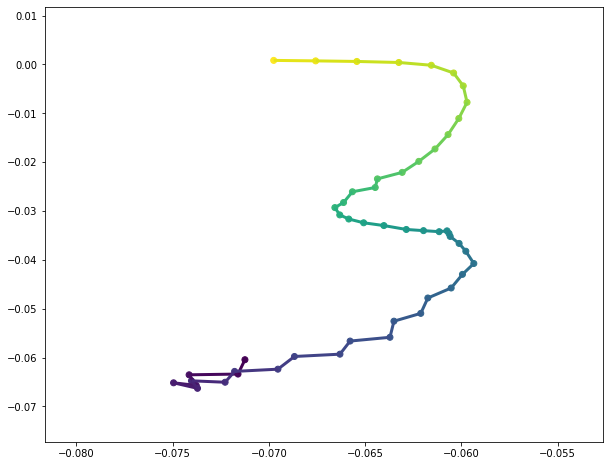

In [9]:
from matplotlib.collections import LineCollection
plt.figure(figsize=(10,8))    
# 2D
plt.scatter(x,y,c=np.arange(number_of_points),cmap='viridis')

# draw a colormapped line through the scatter points
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=plt.get_cmap('viridis'),
    norm=plt.Normalize(0, number_of_points))
lc.set_array(np.arange(number_of_points))
lc.set_linewidth(3)
plt.gca().add_collection(lc)

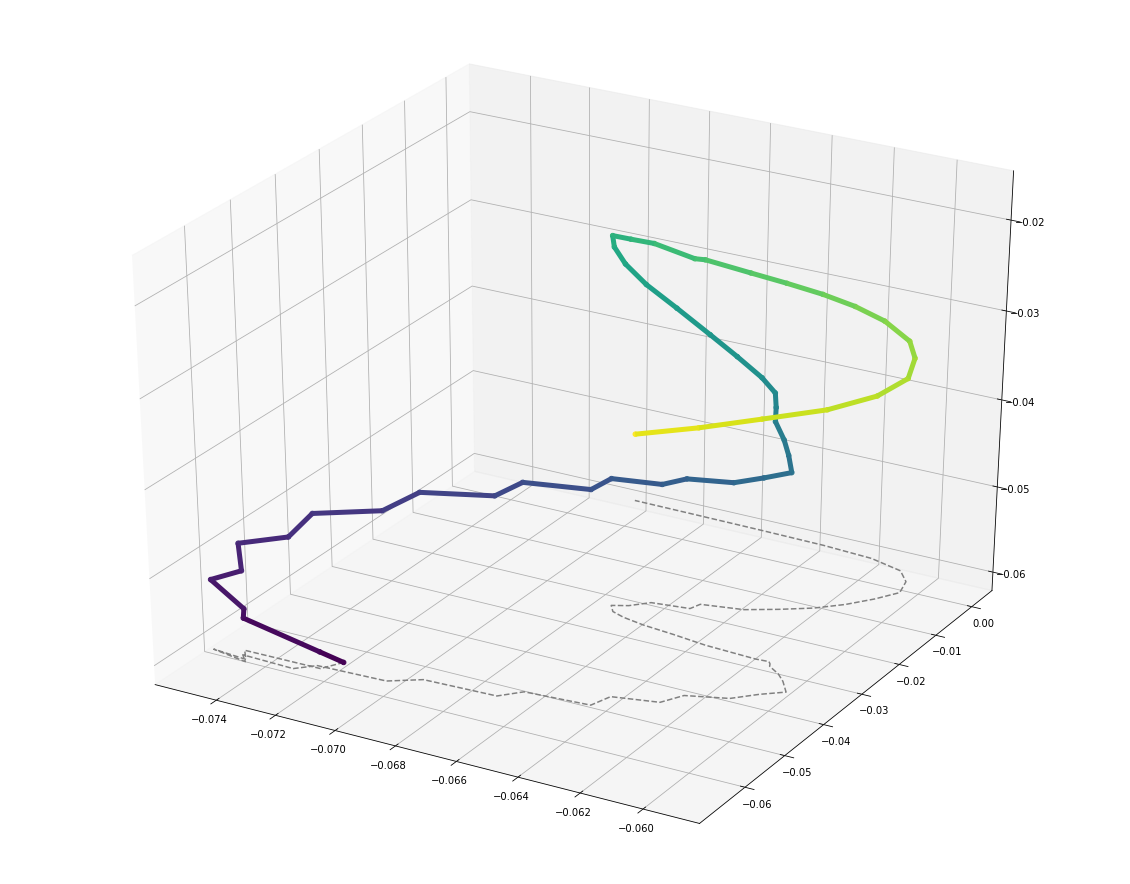

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, BoundaryNorm    
from mpl_toolkits.mplot3d.art3d import Line3DCollection

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection='3d')   

ax.scatter(x,y,z,
           marker='o',
            c=np.arange(number_of_points),
            cmap='viridis',
           alpha=1,
           )

# draw a colormapped line through the scatter points
points = np.array([x, y, z]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = Line3DCollection(segments, cmap=plt.get_cmap('viridis'),
    norm=plt.Normalize(0, number_of_points))
lc.set_array(np.arange(number_of_points))
lc.set_linewidth(5)
plt.gca().add_collection(lc)


# shadows on walls
# ax.plot(x, z, 'r+', zdir='y', zs=1.5)
# ax.plot(y, z, 'g+', zdir='x', zs=-0.5)
ax.plot(x, y, color='grey',linestyle='--', zdir='z', 
        zs=np.min(z)
       )
# ax.set_zlim([-1, 0.2])


### to match up with 2D:
# angle=270
# ax.view_init(90, angle)

## Try some variations by adding noise to latent space:

$\sigma = 0$

In [11]:
_, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
xproj = decoder.predict(ztest + np.random.normal(0,0.25,latent_dim))[0]
animation = animate_stick(xtest, ghost=xproj, ghost_shift=0.2, figsize=(12,8), cmap='inferno')
HTML(animation.to_html5_video())

Skeleton lines: 100%|██████████| 74/74 [00:00<00:00, 1194.52it/s]


$\sigma = 0.5$

In [12]:
xproj = decoder.predict(ztest + np.random.normal(0,0.5,latent_dim))[0]
animation = animate_stick(xtest, ghost=xproj, ghost_shift=0.2, figsize=(12,8), cmap='inferno')
HTML(animation.to_html5_video())

Skeleton lines: 100%|██████████| 74/74 [00:00<00:00, 299.84it/s]


$\sigma = 1$

In [13]:
xproj = decoder.predict(ztest + np.random.normal(0,1,latent_dim))[0]
animation = animate_stick(xtest, ghost=xproj, ghost_shift=0.2, figsize=(12,8), cmap='inferno')
HTML(animation.to_html5_video())

Skeleton lines: 100%|██████████| 74/74 [00:00<00:00, 1197.23it/s]


$\sigma = $big

In [14]:
xproj = decoder.predict(ztest + np.random.normal(0,1.5,latent_dim))[0]
animation = animate_stick(xtest, ghost=xproj, ghost_shift=0.2, figsize=(12,8), cmap='inferno')
HTML(animation.to_html5_video())

Skeleton lines: 100%|██████████| 74/74 [00:00<00:00, 1192.05it/s]


## Try sampling randomly from the latent space:

In [15]:
save_index = 4

In [16]:
sigma = 1
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]

animation = animate_stick(xgen, 
                          cmap='inferno', 
                          figsize=(12,8),
                          cloud=False,
                         )
HTML(animation.to_html5_video())

Skeleton lines: 100%|██████████| 74/74 [00:00<00:00, 1212.60it/s]


Save the animation as a movie with a transparent background:

In [ ]:
animation = animate_stick(xgen, 
                          figsize=(12,8), 
                          cmap='inferno', 
                          cloud=True
                         )
HTML(animation.to_html5_video())

In [ ]:
save_index = save_index + 1

animation.save('gen_transparent_alpha03_'+str(save_index)+'.mov', codec="png",
         dpi=100, bitrate=-1, 
         savefig_kwargs={'transparent': True, 'facecolor': 'none'})

### Progressively larger-sigma variations on the same sequence:

In [ ]:
sigma_increase = 0.1

In [ ]:
sigma = 0
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
animation = animate_stick(xgen, cmap='inferno')
HTML(animation.to_html5_video())

In [ ]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
animation = animate_stick(xgen, cmap='inferno')
HTML(animation.to_html5_video())

In [ ]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
animation = animate_stick(xgen, cmap='inferno')
HTML(animation.to_html5_video())

In [ ]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
animation = animate_stick(xgen, cmap='inferno')
HTML(animation.to_html5_video())

### Large sigma only:

In [ ]:
sigma = 5
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
animation = animate_stick(xgen, cmap='inferno')
HTML(animation.to_html5_video())

# Train a new model:

In [ ]:
seq_len      = 128
latent_dim   = 256
n_layers     = 3 #2
n_units      = 384 #256
use_dense    = True
kl_weight    = 1 #1e-2
resolution   = 3e-1 #1e-2
lr           = 3e-4
do_rotations = True
extrap_len   = seq_len//2
#do_shift     = False
#do_inplace   = False

encoder, decoder, auto, mk_continuizer = mk_seq_ae(ds_all, seq_len=seq_len, latent_dim=latent_dim,
                                   n_units=n_units, n_layers=n_layers,
                                  use_dense=use_dense, kl_weight=kl_weight,
                                  resolution=resolution, do_rotations=do_rotations, extrap_len=extrap_len)
continuizer = mk_continuizer(1)
encoder.summary()
decoder.summary()
auto.summary()

K.set_value(auto.optimizer.lr, lr)

loss_history = []

In [ ]:
# Save the model architecture
with open('vae_lstm_enc_model.json', 'w') as f:
    f.write(encoder.to_json())
with open('vae_lstm_dec_model.json', 'w') as f:
    f.write(decoder.to_json())
with open('vae_lstm_auto_model.json', 'w') as f:
    f.write(auto.to_json())

In [ ]:
batch_size = 128
epochs = 10
lr = 1e-5
kl_weight = 2e-4  # range from 1e-5 to 1e-2
nstep = sum([c-seq_len for c in ds_counts])//batch_size

K.set_value(auto.optimizer.lr, lr) 
K.set_value(auto.hp_kl_weight, kl_weight)

try:
    auto.fit_generator(gen_batches_safe(ds_all_centered, ds_counts, batch_size, seq_len),steps_per_epoch=nstep, epochs=epochs, verbose=1)
    
except KeyboardInterrupt:
    print("Interrupted.")

print("Updating loss history")
loss_history.extend(auto.history.history['loss'])

In [ ]:
nskip = 0
xepochs = np.arange(len(loss_history))+1
plt.plot(xepochs[nskip:], loss_history[nskip:])

In [ ]:
# Save weights:
encoder.save_weights('learning_rate_'+lr+'vae_lstm_enc_weights.h5')
decoder.save_weights('learning_rate_'+lr+'vae_lstm_dec_weights.h5')
auto.save_weights('learning_rate_'+lr+'vae_lstm_auto_weights.h5')

# Save model: 
encoder.save('learning_rate_'+lr+'vae_lstm_enc_model.h5')
decoder.save('learning_rate_'+lr+'vae_lstm_dec_model.h5')
auto.save('learning_rate_'+lr+'vae_lstm_auto_model.h5')